## FPSO Equipment Failure Analysis
### By Vinicius Rogério da Silva
[LinkedIn](https://www.linkedin.com/in/viniciusrogerio/) | [RPubs](https://rpubs.com/viniciusrogerio) | [GitHub](https://github.com/viniciusrogerio)

## Introduction

When it comes to operating an FPSO - Floating Production, Storage, and Offloading vessel -, one concern is the ability to deal with equipment failure. Beyond that, it's of interest to predict whether a pice of machinery is going to fail or not, based on the parameters observed by many sensors. Being able to predict the failure before it happens means we can determine a better schedule for Preventive (or Predictive) Maintenance, saving money by avoiding unnecessary interventions, or worse, unexpected failures.

In this assignment, the goal is to investigate and better understand failures of one specific piece of equipment over time. Above all, we're interested in predicting if the equipment is on the verge of failing, so something can be done before it happens. 


Throughout the report, it's discussed the nature of the failures and their possible reasons, besides some considerations that might be needed in the analysis.

In [45]:
# Loading dependencies
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.compose import make_column_transformer
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics as mt

# Defining seaborn styles for future plots
sns.set_style("ticks")
sns.set_context('notebook')
sns.set_theme()

In [46]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# Reading datafile
path = r"****"
data = pd.read_excel(path)

# Transforming data to a Pandas DataFrame
df = pd.DataFrame(data)

## EDA - Exploratory Data Analysis

In order to better understand the problem we're dealing with, it is mandatory to perform an Exploratory Data Analysis.

In [48]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [49]:
df.tail()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
795,796,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True
796,797,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True
797,798,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True
798,799,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True
799,800,3,1,80.854011,110.543701,121.032227,131.719473,90.331155,71.261717,True


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


### Some initial notes:

The dataset has 10 variables and their types are described above. "Fail" is our variable of interest. "Cycle" indicates which time cycle is being measured (800 in total). Although we might have no idea of the time unit being used, the way data is displayed over cycles gives us an idea of a **time-series**, **and it seems reasonable to assume that it's distributed over days**. "Preset_1" and "Preset_2" are setup configurations for the equipment. "Temperature" and "Pressure" are physicochemical parameters as their name suggest. "VibrationX", "VibrationY" and "VibrationZ" seem to measure vibration of the equipment on the three spatial axes. It's not very clear what is represented by variable "Frequency". But if we assume that the functioning of the equipment depends on some type of rotation or cyclical movement, it probably indicates at which frequency it's running.

### Failures over time

#### Before going into any further analysis, let's take a deep and careful look at our variable of interest. 

In [51]:
# Computing number and percentage of failures
print(len(df.loc[df["Fail"]==True]))
print(len(df.loc[df["Fail"]==True])/len(df))

66
0.0825


The equipment had 66 failing cycles. This represents 8.25% of the overall observed behavior of the machinery.

#### The graph below shows how the failure occurrences are distributed over time:

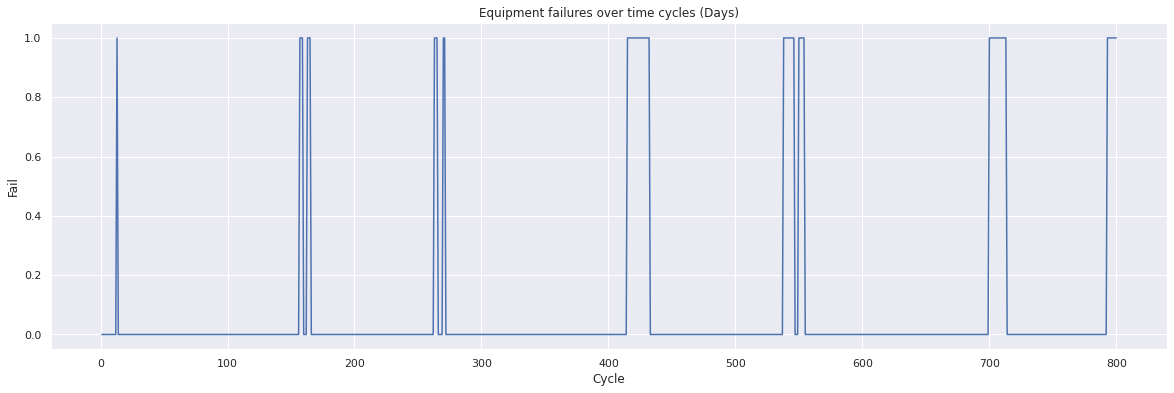

In [52]:
%matplotlib inline

# Plot setup
plt.figure(figsize=(20,6))
sns.lineplot(x = "Cycle", y = "Fail", data=df)
plt.title("Equipment failures over time cycles (Days)")
plt.show()

#### If we assume that **each cycle represents a day**, some things pop up when we analyse the graph above:

- The duration of the failure may vary. Sometimes the equipment fails for only one day and then comes back to function. In other cases, it seems to fail and keep that status for some cycles.
- Other observation is that some failures that seem separated might actually be a part of the same event. Maybe the equipment was under maintenance for a certain number of cycles, and while that happened, it switched between the two states before going back to full function. Other hypothesis is that the equipment had to be turned on and off for testing while under maintenance.
- If we assume the above as true, it might be interesting to see these separated failures grouped as one single failure occurrence. Two approaches seem reasonable to achieve that goal:
    - To consider the observations inbetween two minor failures as a failure as well - that is, simply assign `Fail = True` to these datapoints. The problem here is that we have no idea of the real reason why the data was labeled as a non-failure. That would be a somewhat audacious decision, based on a hypothesis that might be untrue, and that could carry unwanted bias to the analysis.
    - To remove datapoints inbetween two minor failures, so the resulting datapoints have only major failure groups. The problem associated with this approach is that we'll be deciding to throw data away. But as will be shown further, the number of datapoints to be dropped is very small compared to the size of the whole dataset. Also, there's the advantage of taking no bias, since no labeling is gonna be changed. **For these reasons, this option is the one that has been chose**. 


Code below finds beginning and ending cycles of each failure, so that manipulation can be performed.

In [53]:
# Defining a function to give beginning, end and duration of failures

def getDuration(df_):

  # Defining lists for tracking beginning and end of failures
  starts_ = []
  ends_ = []

  # Iterating over cycles to identify failures
  for i in range(0,len(df_)-1):
    if df_.iloc[(i-1),-1] == False and df_.iloc[i,-1] == True:
      starts_.append(i+1)
    if df_.iloc[(i+1),-1] == False and df_.iloc[i,-1] == True:
      ends_.append(i+1)

  # Including last observation, not treated by the loop
  ends_.append(len(df_))

  duration_ = []

  # Iterating over failures to calculate their duration
  for i in range(0,len(starts_)):
    curr_duration = ends_[i] - starts_[i] + 1
    duration_.append(curr_duration)
  
  return [starts_,ends_,duration_]

starts, ends, duration = getDuration(df)

print(starts)
print(ends)
print(duration)

print("Mean days at failure (before dropping): ", np.mean(duration))

[13, 157, 163, 263, 270, 415, 538, 550, 700, 793]
[13, 159, 165, 265, 271, 432, 546, 554, 713, 800]
[1, 3, 3, 3, 2, 18, 9, 5, 14, 8]
Mean days at failure (before dropping):  6.6


#### As shown above, the mean duration of a major failure event before we drop unwanted datapoints is from 6 to 7 days.

Code below defines the observations to be removed, based on the reasoning already explained before.

In [54]:
# Creating list of unwanted datapoints
droplist = [*range(159,162),*range(265,269),*range(546,549)]

# Removing unwanted datapoints
df = df.drop(droplist, axis=0)

After removing these cycles, we must as well transform our Cycle variable. If we didn't do so, we would be treating our problem as if we still had the original 800 cycles, and that is untrue.

In [55]:
len(df)
# 10 cycles have been deleted in total

790

In [56]:
# Defining new variable for fixing the cycles
Cycles = [*range(1,(len(df)+1))]
df["Cycle"] = Cycles

# Reseting row numbers of the datapoints
df.reset_index(drop=True, inplace=True)

In [57]:
# Examining the new dataset
print(np.max(df["Cycle"]))
print(df["Cycle"].info())
df.tail()

790
<class 'pandas.core.series.Series'>
RangeIndex: 790 entries, 0 to 789
Series name: Cycle
Non-Null Count  Dtype
--------------  -----
790 non-null    int64
dtypes: int64(1)
memory usage: 6.3 KB
None


,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
785,786,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True
786,787,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True
787,788,1,4,79.777294,110.535405,61.334995,149.577811,129.463843,70.853353,True
788,789,2,8,79.360314,159.985443,61.762879,169.773831,130.213426,80.113540,True
789,790,3,1,80.854011,110.543701,121.032227,131.719473,90.331155,71.261717,True


#### Now that these manipulations have already been performed, we can visualize the result:

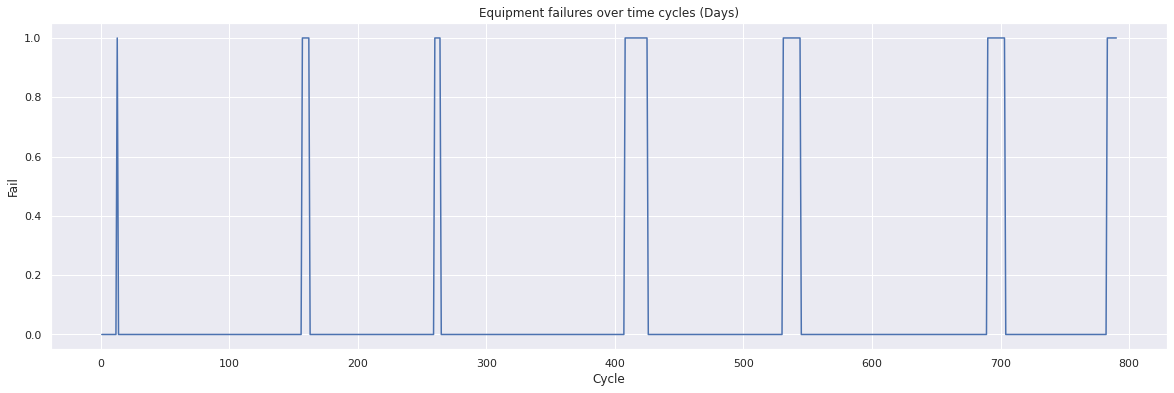

In [58]:
%matplotlib inline
# Plot setup
plt.figure(figsize=(20,6))
sns.lineplot(x = "Cycle", y = "Fail", data=df)
plt.title("Equipment failures over time cycles (Days)")
plt.show()

#### As we can see above, it now makes more sense to have these failures grouped, and we can also recalculate the number of occurrences and the mean duration of a failure.

In [59]:
# Retrieving failures for the new dataset
starts, ends, duration = getDuration(df)

print(starts)
print(ends)
print(duration)
print("Mean days at failure (after dropping): ", np.mean(duration))

[13, 157, 260, 408, 531, 690, 783]
[13, 162, 264, 425, 544, 703, 790]
[1, 6, 5, 18, 14, 14, 8]
Mean days at failure (after dropping):  9.428571428571429


#### We now see that the mean duration of a failure, after removing observations inbetween minor failures, is more than 9 days.

### Failures related to other variables

In this subsection we'll try to visualize how the other variables behave before a failure occur. At first, we'll look exclusively at the continuous ones. In the graphs, orange lines indicate the countinuous variable currently being analysed, while blue lines indicate failures.

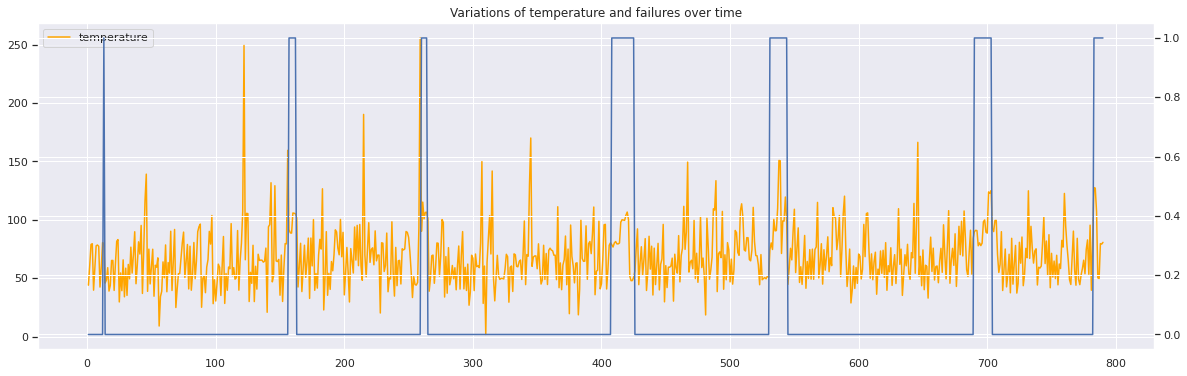

In [60]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["Temperature"]], color = "orange", label="temperature")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]], label="failures")
plt.title("Variations of temperature and failures over time")
plt.show()

When it comes to the relation between temperature and failure, it seems that some days before a failure occurs, the temperature shows a peak that goes at least beyond 150 units. Maybe there's a threshold supported by this specific equipment, that might contribute to a failure days after it's trespassed.

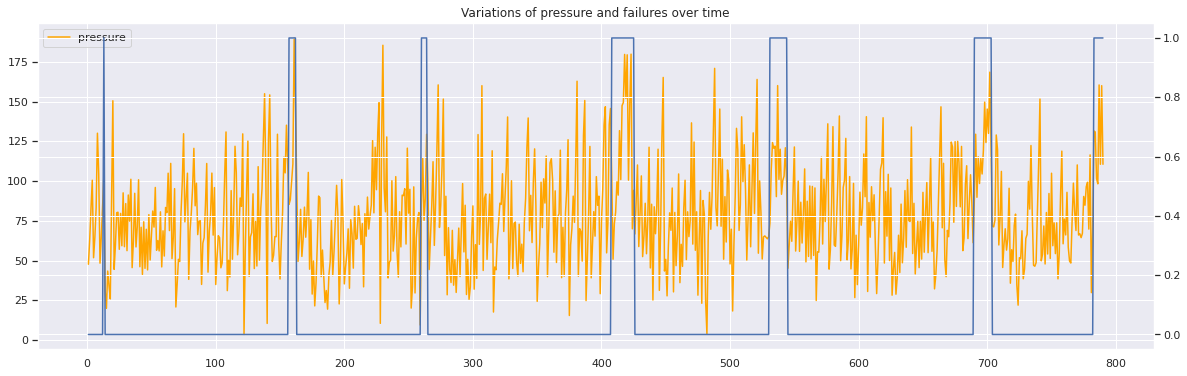

In [61]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["Pressure"]], color = "orange", label="pressure")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of pressure and failures over time")
plt.show()

Pressure seems to increase during some of the failure events, when compared to the pressure observed a couple days before the event happens.

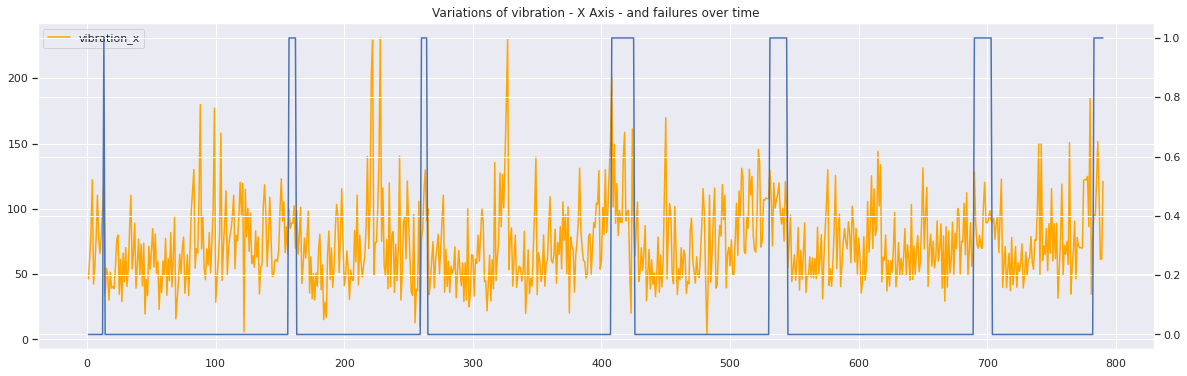

In [62]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["VibrationX"]], color = "orange",label="vibration_x")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of vibration - X Axis - and failures over time")
plt.show()

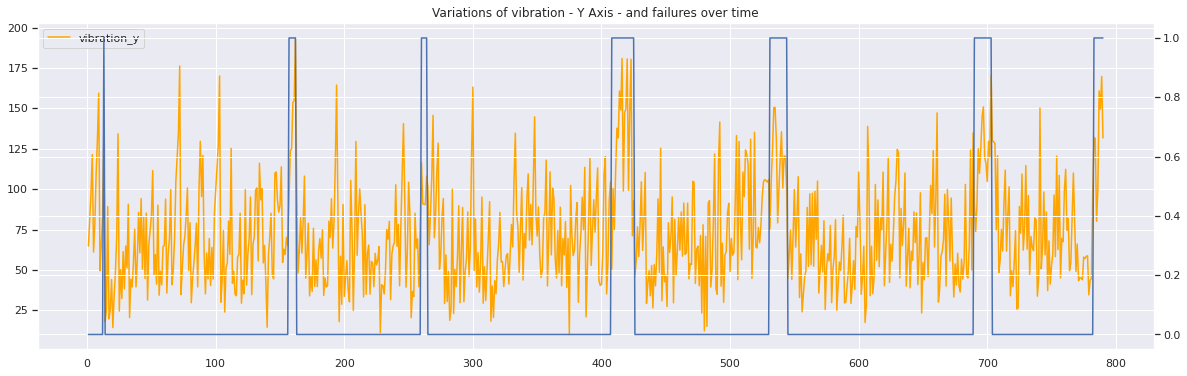

In [63]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["VibrationY"]], color = "orange",label="vibration_y")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of vibration - Y Axis - and failures over time")
plt.show()

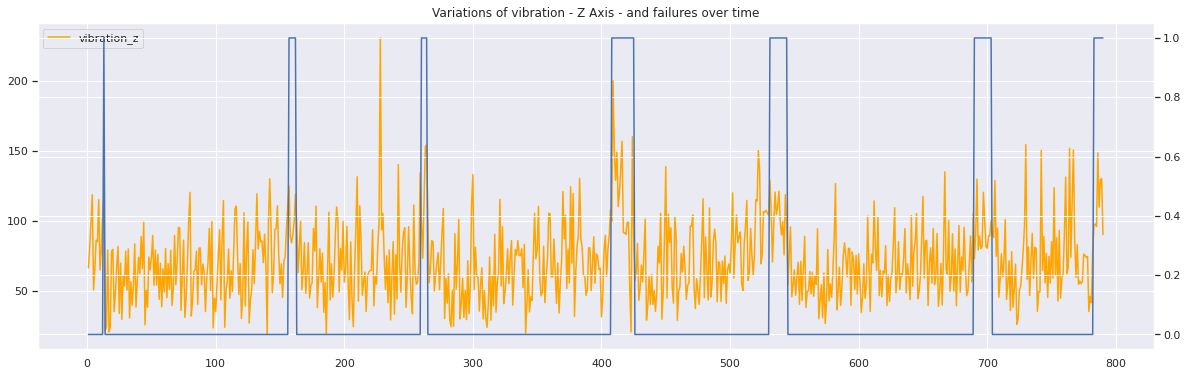

In [64]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["VibrationZ"]], color = "orange",label="vibration_z")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of vibration - Z Axis - and failures over time")
plt.show()

#### Let's treat the three axes as if we're talking about a Vector and calculate it's norm.

In [65]:
# Calculating vector norm
norm = [np.sqrt(df.loc[i,"VibrationX"]**2 + df.loc[i,"VibrationY"]**2 + df.loc[i,"VibrationZ"]**2) for i in range(0,len(df))]
len(norm)
df["Norm"] = norm

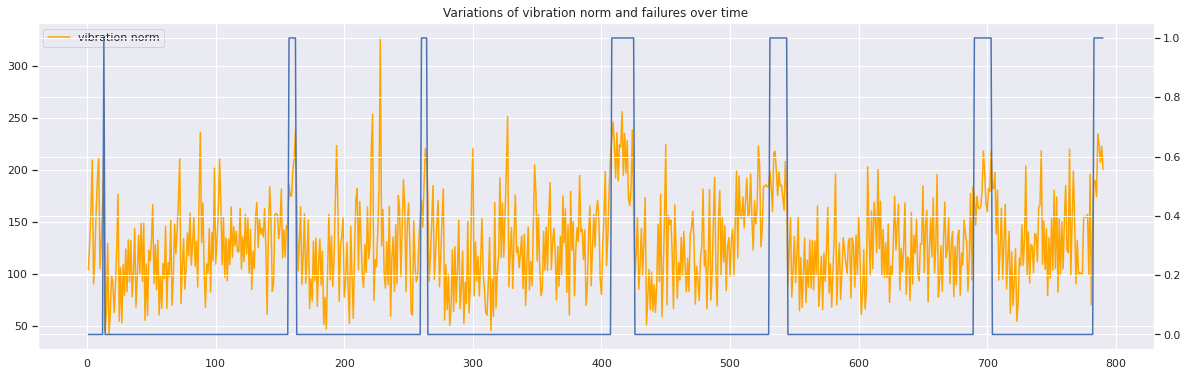

In [66]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],norm, color = "orange",label="vibration norm")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of vibration norm and failures over time")
plt.show()

When it comes to the vibration observed on the equipment, the axes don't give much information when isolated. But if we treat it like a vector in space and compute the norm of the vector, **there seems to exist a slight growing trend on the days that preceed the failure.** Aditional statistical testing could be performed to confirm if that trend in fact exists.

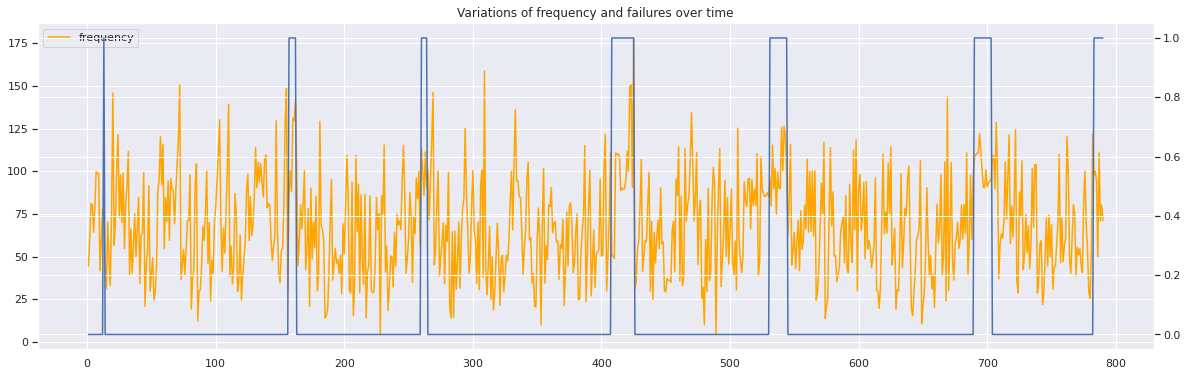

In [67]:
%matplotlib inline
fig, ax1 = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1.plot(df[["Cycle"]],df[["Frequency"]], color = "orange",label="frequency")
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(df[["Cycle"]],df[["Fail"]])
plt.title("Variations of frequency and failures over time")
plt.show()

From the graph above, it's hard to find any influence of the frequency on the failures.

#### It's important to point out that these graphs only help us having a better idea of how the continuous variables behave over time in comparison to the failures. We cannot assume any kind of correlation just by looking at these.

It might also be interesting to visualize the form of the distribution of each variable:

Text(0.5, 1.0, 'Continuous variables distribution')

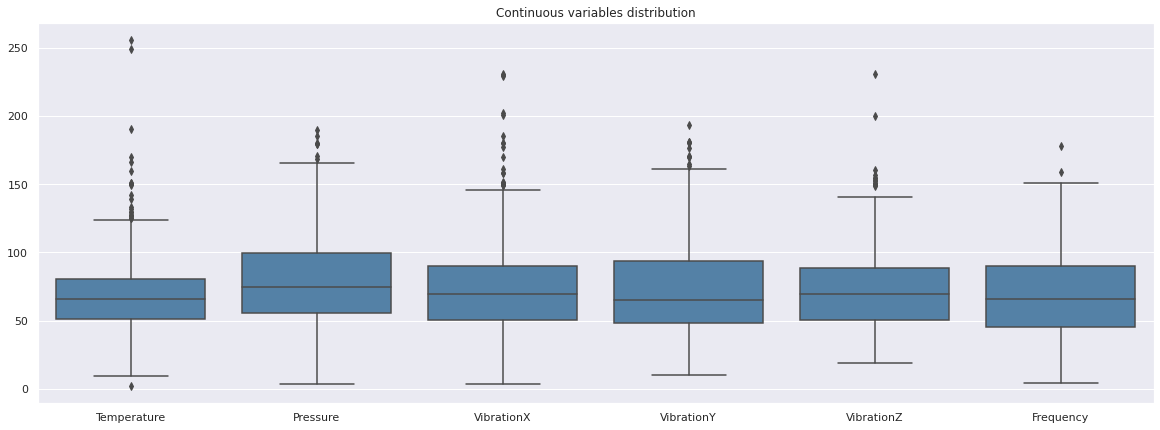

In [68]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df.iloc[:,3:9], ax=ax, color="steelblue")
plt.title("Continuous variables distribution")

#### The distribution of the continuous variables is considerably well behaved, with no severe skewness for none of them (although we need to considerate their scales are different).

We can also obtain a pairplot of these variables:

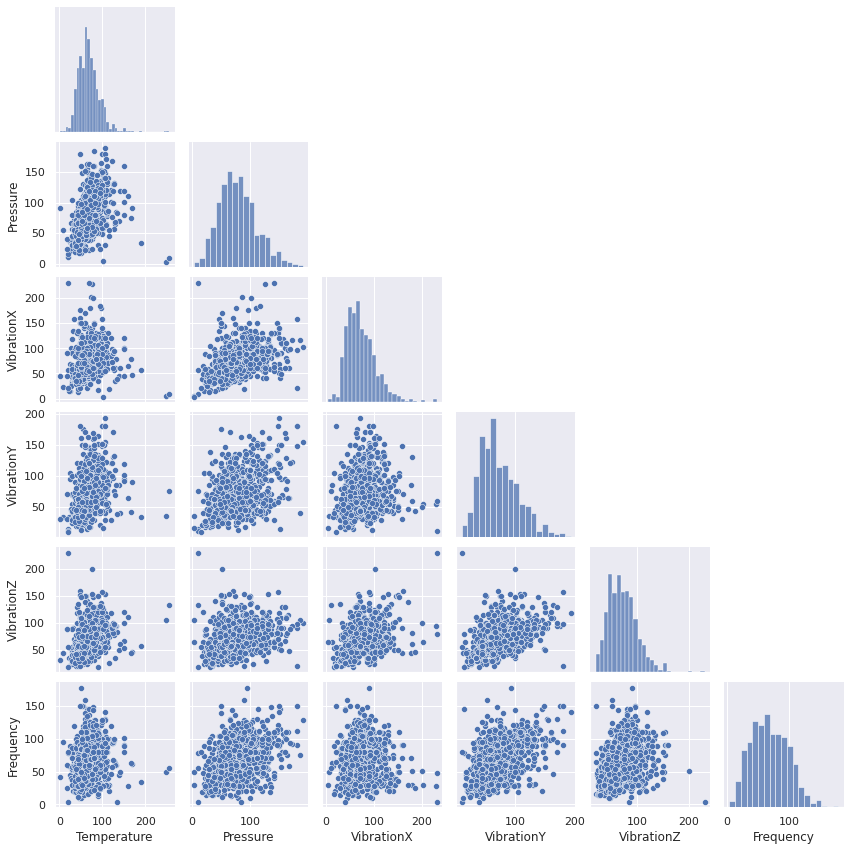

In [69]:
sns.pairplot(df.iloc[:,3:9],corner=True,height=2)
plt.show()

#### We can see a positive relation between Temperature and Pressure, which makes sense, since they're phisically interdependent. It's also possible to note positive relations among the variables that measure vibration on the three axes. Temperature and Pressure are the ones that seem to have a positive correlation with all the other variables.

Although no correlation coefficient has been calculated and these relations might not even be linear, this graph can help us having more insights about the problem. We could also perform t-tests for correlation between these variables, but its not gonna be the focus here.

### Failures and Setup Configurations (Preset1 and Preset2)

The dataset has two categorical variables that indicate possible setup configurations for the equipment. Let's take a quick look at them:

In [70]:
# Retrieving categories of Preset variables
print(np.unique(df["Preset_1"]))
print(np.unique(df["Preset_2"]))

[1 2 3]
[1 2 3 4 5 6 7 8]


#### There are two levels for Preset_1 and 8 levels for Preset_2, giving us a total of 24 possible configurations of the equipment, each one resulted by varying both of the individual presets.

Since each one of the possible configurations might lead to a different behaviour of the equipment, let's create a new variable to analyse how the failures are distributed over them.

In [71]:
# Defining lists for Preset variables
preset1 = df["Preset_1"]
preset2 = df["Preset_2"]

# Creating new variable with the two presets combined
Config = ["("+str(preset1[i])+","+str(preset2[i])+")" for i in range(0,len(preset1))]

# Adding new variable to the dataset
df["Config"] = Config

df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Norm,Config
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,103.801329,"(3,6)"
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,130.232621,"(2,4)"
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,161.994313,"(2,1)"
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,209.236814,"(2,3)"
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,90.029176,"(2,5)"


Now that the variable combining the two presets has been created, we can examinate how the failures are distributed over them:

<ipython-input-72-dd76a4dbf3fb>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = df, y = df.Config.value_counts().index,


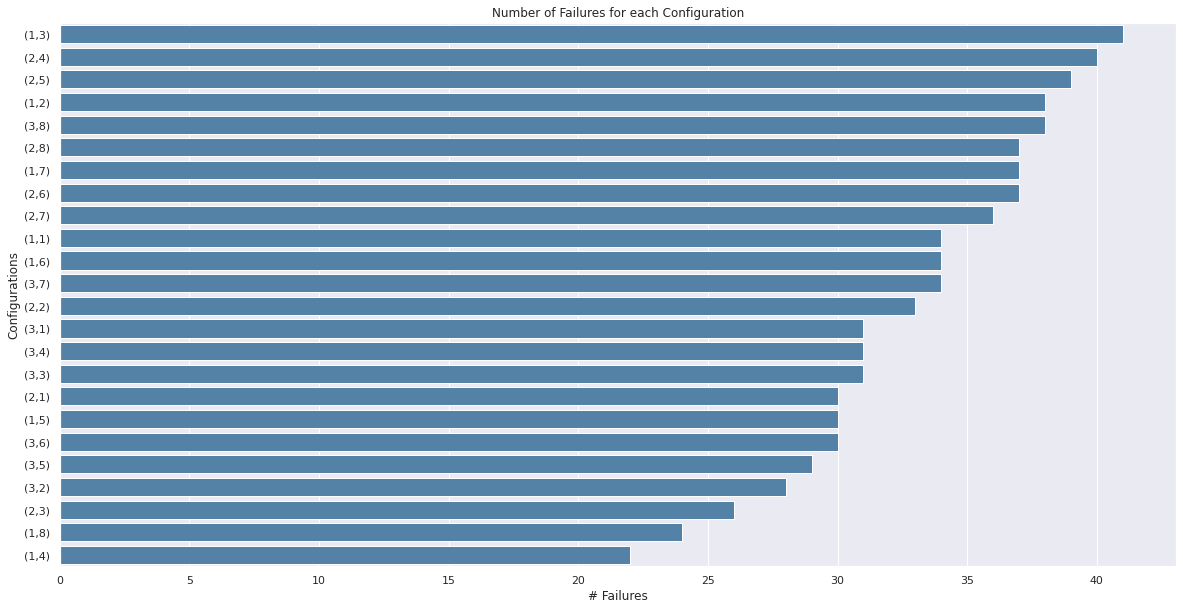

In [72]:
# Plot setup
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data = df, y = df.Config.value_counts().index,
            x = df.Config.value_counts().values,
            orient="h", palette=None, ax=ax, ci=None, color="steelblue")
plt.title("Number of Failures for each Configuration")
plt.xlabel("# Failures")
plt.ylabel("Configurations")
plt.show()

#### Failures are more common when `Preset_1 = 1` and `Preset_2 = 3`. In other hand, the configuration which led to the least number of failure is `Preset_1 = 1` and `Preset_2 = 4`.

At this point, it's not clear if the configuration of the equipament really plays an important role on the failure or if it's just a coincidence. Maybe the configurations that led to more failures are just the ones being used most of the time for some reason, and thus it's natural that they appear in a higher number of events.

## Defining a new target variable

### Failure vs Pre Failure

Now that we have a better ideia about how the failures are distributed over time and in relation to the other variables, we can think about a good strategy for modeling and predicting the failure event.

Operating and maintaining an FPSO is very expensive. If the equipment in question plays a fundamental role, then having it down for a large period can lead to high costs. Thus, there's not much interest in predicting the failure when it happens itself, because if the equipment fails, we're already facing our worst scenario. **Therefore, we want to predict the failure in advance, so something can be done before it happens**.

To do so, one possible strategy is to **shift our target variable days ahead**. That is, we're going to transform the failure variable so the value on each observation is actually pointing out that a failure occurred a certain number of days later. **The way of thinking will then change from "the failure event occurred at this cycle" to "a failure event occurred N cycles after the current one".**

It's not certain how many days are ideal for initiating maintenance upfront. At this first moment, it's defined that we want our failure to be predicted **one day before**.

The following code manipulates the original variables to put them in a more suitable way.

In [73]:
# Defining number of days to be considered as pre-failure
days = 1

df_new = df.copy()

# Applying shiftting to the desired variable
df_new['Fail_shifted'] = df_new['Fail'].shift(-days)

df_new = df_new.iloc[0:len(df_new)-days,:]
df_new = df_new.astype({"Fail_shifted":"int"})

# Creating "Status" variable
status = df_new["Fail"]
status = ["failure" if x else "normal" for x in status]

for i in range(0,len(status)):
  if status[i] == "failure" and status[i-1]=="normal": 
    for j in range(i-days,i):
      status[j]="pre_failure"

df_new["Status"] = status

df_new.tail(n=12)

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Norm,Config,Fail_shifted,Status
777,778,1,5,82.942913,99.210657,124.847286,58.777670,74.652973,53.873592,False,156.890808,"(1,5)",0,normal
778,779,3,2,53.550958,69.756841,86.434752,34.537847,35.164659,29.083565,False,99.500666,"(3,2)",0,normal
779,780,2,3,95.545013,116.444262,185.134217,43.649276,46.005316,25.454444,False,195.694728,"(2,3)",0,normal
780,781,3,7,39.909918,29.797831,34.575632,44.560622,41.588444,53.584668,False,70.076544,"(3,7)",0,normal
781,782,2,7,84.990752,70.507201,78.673752,96.382638,79.131822,121.850581,False,147.448355,"(2,7)",1,pre_failure
782,783,1,6,127.670754,131.515898,95.582845,132.053899,97.254115,97.776491,True,189.822747,"(1,6)",1,failure
783,784,1,1,127.241746,130.866581,94.530934,131.437235,97.778930,100.064043,True,189.136362,"(1,1)",1,failure
784,785,2,7,107.452875,101.617775,121.179986,80.182308,96.035159,94.125167,True,174.173888,"(2,7)",1,failure
785,786,2,6,50.469522,98.235421,151.585252,99.341380,148.838481,49.841400,True,234.520131,"(2,6)",1,failure
786,787,1,4,49.985270,160.433640,110.953010,160.777175,109.917566,110.919290,True,224.146697,"(1,4)",1,failure


#### "Fail_shifted" is the new target variable that is gonna be used to fit our model.

### Distribution of continuous variables at each status

It is interesting to note how each continuous variable behaves in and out of failure.

<Axes: xlabel='Norm', ylabel='Density'>

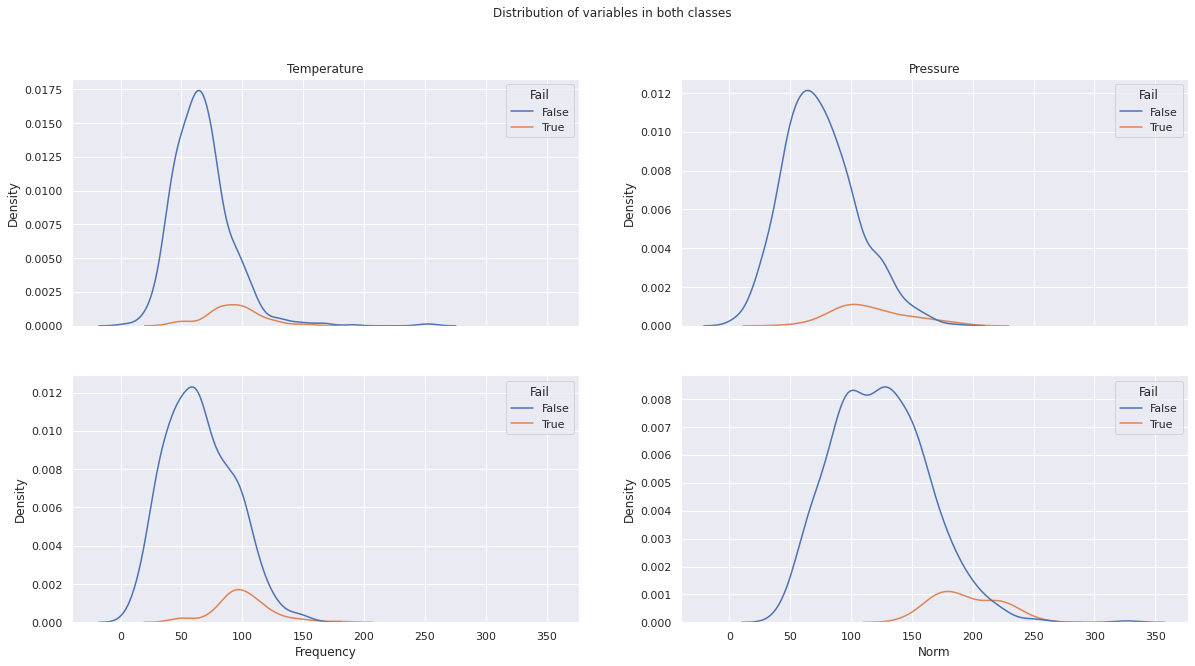

In [74]:
figure, axes = plt.subplots(2, 2, sharex=True, figsize=(20,10))
figure.suptitle('Distribution of variables in both classes')
axes[0,0].set_title('Temperature')
axes[0,1].set_title('Pressure')
# axes[1,0].set_title('Frequency')
# axes[1,1].set_title('Norm')

sns.kdeplot(ax=axes[0, 0], data=df_new, x="Temperature", hue="Fail")
sns.kdeplot(ax=axes[0, 1], data=df_new, x="Pressure", hue="Fail")
sns.kdeplot(ax=axes[1, 0], data=df_new, x="Frequency", hue="Fail")
sns.kdeplot(ax=axes[1, 1], data=df_new, x="Norm", hue="Fail")


#### We see that the center of the distributions for Temperature, Pressure, Frequency and Vibration Norm all get delocated to right when the equipment is at failure, compared to the normal state. This is another evidence that might indicate that increasing the value of these variables might lead to failure.

### Model fit

Tree-based models are well known for their good performance among many classification tasks, including classificating anomalies such as the one being treated in this assignment. They also have better performance than other more complex models when it comes to smaller datasets. Beyond that, the process of fitting Decision Trees is quite simple and involves considerably low computational cost. So, for these reasons, this is the type of model that is gonna be used.


### Stratified K-fold Cross Validation

*Note: given the nature of the dataset, a time-based approach would be more correct, specially in terms of avoiding data leakage. A better way to perform this evaluation would be through TimeSeriesSplit. By the time this assignment have been developed, I wasn't really aware of that.*

There are many methods for evaluating model performance when it comes to binary classification. One of the most common ones is the use of **K-fold Cross Validation**, which consists of partitioning the original dataset in K subsets (folds) and then train/test the model step by step. At each step, the model is trained using K-1 subsets and tested on the remaining one. This process is more reliable than evaluating the performance over a single train/test combination.

When it comes to unbalanced data (as in our case), one concern is that the positive (or negative) class might not be seen in the training set, so the model won't be able to identify it when it gets into production. To prevent that from happening, the process of splitting the dataset into train and test subsets must be **stratified**, that is, the proportion of positive and negative classes is kept about the same of the original dataset. In this way we can assure that each partition gives a reliable representation of our original data.

The technique has been applied using K = 10, which is a common go for this type of application. Following code performs the fitting of the models and also retrieves the main performance metrics for binary classification and their average over the resulted 10 folds.

In [75]:
# Selecting variables for model fit
newdata = df_new.iloc[:,3:].copy()
newdata = newdata.drop(labels=["Config","Fail","Status"],axis=1)
newdata.tail(n=15)

,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Norm,Fail_shifted
774,65.582650,90.293802,121.965150,57.958996,76.257946,82.423653,155.080680,0
775,53.988060,84.771284,122.681568,57.030306,75.358708,100.037437,154.861738,0
776,74.842740,96.454425,122.021434,58.386355,73.888173,68.641088,154.135197,0
777,82.942913,99.210657,124.847286,58.777670,74.652973,53.873592,156.890808,0
778,53.550958,69.756841,86.434752,34.537847,35.164659,29.083565,99.500666,0
779,95.545013,116.444262,185.134217,43.649276,46.005316,25.454444,195.694728,0
780,39.909918,29.797831,34.575632,44.560622,41.588444,53.584668,70.076544,0
781,84.990752,70.507201,78.673752,96.382638,79.131822,121.850581,147.448355,1
782,127.670754,131.515898,95.582845,132.053899,97.254115,97.776491,189.822747,1
783,127.241746,130.866581,94.530934,131.437235,97.778930,100.064043,189.136362,1


In [76]:
# Selecting variables for model fit
X = newdata.iloc[:,0:-1]
y = newdata["Fail_shifted"]

# Defining a seed for replicability purposes
seed = 1

# New instance of DecisionTreeClassifier
treeobj = tree.DecisionTreeClassifier(random_state = seed)

# Using stratified k-fold cross validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# Defining lists that are going to receive the resulting metrics
accuracies = []
recalls = []
precisions = []
f1scores = []
importances = []

for train_index, test_index in skf.split(X, y):
	
	# Obtaining train and test subsets for each current fold
	X_train_fold, X_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
	y_train_fold, y_test_fold = y[train_index], y[test_index]

	# Fitting the model on the current fold
	model_fold = treeobj.fit(X_train_fold, y_train_fold)
 
	# Getting predicted outcomes for current fold
	outcome = model_fold.predict(X_test_fold)
	
	# Retrieving feature importances
	importance = model_fold.feature_importances_
	importances.append(importance)

	# Calculating performance metrics for current fold
	precision_score = mt.precision_score(y_test_fold, outcome)
	recall_score = mt.recall_score(y_test_fold, outcome)
	f1_score = mt.f1_score(y_test_fold, outcome)
	accuracy_score = mt.accuracy_score(y_test_fold, outcome)

	# Storing metrics into their lists
	accuracies.append(accuracy_score)
	precisions.append(precision_score)
	recalls.append(recall_score)
	f1scores.append(f1_score)

# Output of the obtained metrics
print("\n Recall")
print(np.round(recalls,4))
print("Mean over 10-fold CV: ",np.mean(recalls))
print("\n Precision")
print(np.round(precisions,4))
print("Mean over 10-fold CV: ",np.mean(precisions))
print("\n F1-Score")
print(np.round(f1scores,4))
print("Mean over 10-fold CV: ",np.mean(f1scores))
print("\n Accuracy")
print(np.round(accuracies,4))
print("Mean over 10-fold CV: ",np.mean(accuracies))


 Recall
[0.3333 0.3333 0.5    0.7143 0.7143 0.2857 0.7143 0.4286 0.7143 0.8333]
Mean over 10-fold CV:  0.5571428571428572

 Precision
[0.2857 0.3333 0.4286 0.625  0.5    0.4    0.5556 0.75   0.625  0.5   ]
Mean over 10-fold CV:  0.5003174603174603

 F1-Score
[0.3077 0.3333 0.4615 0.6667 0.5882 0.3333 0.625  0.5455 0.6667 0.625 ]
Mean over 10-fold CV:  0.5152920608802962

 Accuracy
[0.8861 0.8987 0.9114 0.9367 0.9114 0.8987 0.9241 0.9367 0.9367 0.9231]
Mean over 10-fold CV:  0.9163583252190847


### Which metric suits best for our problem?

In the problem we're dealing with, if the equipment plays an important role to the functioning of the FPSO, there's probably a very high cost related to the failure. If we think in terms of Type 1 and Type 2 errors, in our case it seems way worse to have a failure that has not been identified (a false negative) than to state that a failure will occur and it doesn't occur (a false positive).

#### The best metric to consider when there's a high cost associated with false negatives is Recall. We have an average recall of 0.56, and considering the lack of more information on the problem and about the functioning of the equipment, that's at least a good starting point.

### Feature importance

Feature importance is a way to analyse how much each one of the variables contribute to the model. That is, the "amount" of each variable that is being used to explain the (shifted) failure event. They have been calculated at each fold of the cross validation process, so now it's possible to get an average result:

In [77]:
importances = pd.DataFrame(importances)

feats = []

for column, value in importances.iteritems():
  feats.append(np.mean(value))

print("Feature importances over all 10 folds: ")
print(importances)

print("\nMean importances over 10 folds: ")
print(feats)

Feature importances over all 10 folds: 
          0         1         2         3         4         5         6
0  0.128414  0.084468  0.089321  0.061629  0.012137  0.282453  0.341579
1  0.262487  0.090223  0.051581  0.111996  0.000000  0.165223  0.318490
2  0.087554  0.078101  0.119645  0.051002  0.045837  0.271920  0.345941
3  0.201648  0.135605  0.027963  0.059465  0.039945  0.192483  0.342892
4  0.133776  0.109975  0.080622  0.032014  0.042754  0.303513  0.297345
5  0.201697  0.106307  0.020211  0.098713  0.084482  0.141544  0.347046
6  0.087318  0.105379  0.051563  0.091262  0.047468  0.268250  0.348759
7  0.250957  0.074573  0.071563  0.052650  0.055944  0.187860  0.306453
8  0.131372  0.103625  0.084071  0.042330  0.025228  0.298251  0.315122
9  0.082016  0.061560  0.107755  0.076515  0.059615  0.260176  0.352364

Mean importances over 10 folds: 
[0.15672401063611613, 0.09498157820190345, 0.07042943175188662, 0.0677576163460423, 0.04134103986048593, 0.2371673034493714, 0.3315990

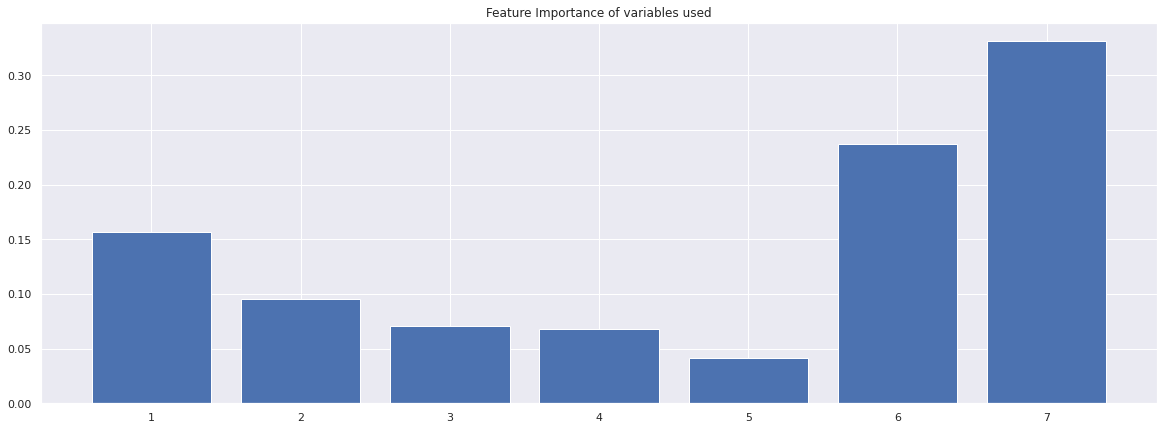

In [78]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.bar([x+1 for x in range(0,len(feats))], feats)
plt.title('Feature Importance of variables used')
plt.show()

#### As shown above, the variables representing the highest importances are Vibration Norm (7), Frequency (6) and Temperature (1). 

Since we're assuming a rotation equipment, it makes a lot of sense to have Vibration Norm as the most important variable. This gives an idea that the failure of the equipment might be highly influenced by external disturbances on it's rotation. Same reasoning can be applied to Frequency variable, since a disturbance in the rotation can lead to a change in frequency.

## Conclusion

We've analysed a dataset containing informations of some sort of rotating equipment that is part of an FPSO. After taking many hypothesis into account, it was possible to better understand the failures of this piece of machinery and which variables might be leading to it. Through stratified cross validation, we also adjusted a Decision Tree model that is a good starting point for predicting the failure before it happens, assuming a time span of 1 day before. Here are some of the main insights:

- If we consider the failure as the major event that contains many cycles, then the equipment has failed 7 times, with a mean duration of 9 days at each failure;
- Some configurations seem to be more related to failures, but that's not necessarily a causal relation. Maybe the configuration setups with more failures are just the ones used more often;
- Initial graphs and further variable importance indicate that Vibration, Frequency and Temperature have considerable influence on the failures;
- Our final model has a recall of 0.56 and a precision of 0.5. The overall accuracy is at about 0.92, although it's not a good metric for evaluating performance in this case;

### For future improvements

It's possible to explore other resources to enrich this analysis:

- Configuration Setups could be added to the model to see if they would give any more information or result in a better recall. The problem here is that, with 24 classes, there's a considerable computational cost related to the encoding;
- Other models could be explored, such as Random Forests and Logistic Regression, to compare the performance with the obtained Decision Tree;
- If possible, collecting more data could give more examples of the positive class, and that could give us a better recall;
- Finally, regarding this report, code refactoring could be performed to enhance performance, replicability and readability. A deeper literature review could also give a better reference on the field and a better idea of this type of problem.  
         




In [80]:
!jupyter nbconvert --to html /content/drive/MyDrive/Colab_Notebooks/Failure_Analysis.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Failure_Analysis.ipynb to html
[NbConvertApp] Writing 2358671 bytes to /content/drive/MyDrive/Colab_Notebooks/Failure_Analysis.html
